In [514]:
import requests
from bs4 import BeautifulSoup 
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

# Парсинг

In [123]:
# https://auto.ru/moskva/cars/all/do-500000/?price_from=200000&year_from=2010

# https://auto.ru/moskva/cars/all/do-500000/?page=2&price_from=200000&year_from=2010

# получение html скрипта
def get_html(url):
    r = requests.get(url)
    r.encoding = 'utf8'
    r = r.text
    return r # Возвращаем html код

# получение кол-ва страниц
def get_total_pages(html):
    soup = BeautifulSoup(html, 'lxml') # объект soup
    
    pages = soup.find('div', class_ = 'ListingPagination-module__container').find_all('a', class_ = 'Button')[-3].get('href')
    total_pages = pages.split('=')[1].split('&')[0]
    
    return int(total_pages)

# запись в файл csv
def save_pandas(data):
    #path = 'C:\\Users\\GreenData\\Desktop\\ML\\ДТЗ\\'
    dt = pd.DataFrame(data)
    #dt.to_csv(path + 'data.csv', encoding='cp866')
    return dt
    
# получение данных со страниц поиска
def get_page_data(html):
    soup = BeautifulSoup(html, 'lxml') # объект soup
    
    ads = soup.find_all('div', class_ = 'ListingItem-module__container')
    #print(ads)
    for ind, ad in enumerate(ads):
        try:
            mark = ad.find('div', class_ = 'ListingItem-module__description').find('h3').text.split(' ')
            car = mark[1:]
            mark = mark[0]
            if 'Рестайлинг' in car:            
                restal = 1
                model = ' '.join(car[:-1])
            else:
                restal = 0
                model = ' '.join(car)
        except:
            mark = np.nan
            restal = np.nan
            model = np.nan
        
        #ссылка
        try:
            url = ad.find('div', class_ = 'ListingItem-module__description').find('h3').find('a').get('href')
        except:
            url = np.nan   
        
        # цена
        try:
            price = float(ad.find('div', class_ = 'ListingItemPrice-module__content').text.replace('\xa0', '').replace('\xa0', '').replace('₽', ''))
        except:
            price = np.nan     
        
        # объем двигателя, л.с., Топливо, КП, Кузов, Привод, Цвет
        try:
            a = ad.find_all('div', class_ = 'ListingItemTechSummaryDesktop__cell')
            feat = list()
            for i, el in enumerate(a):
                if i == 0:
                    feat.append(el.text.replace('л\u2009/\u2009', '').replace('\xa0л.с.\u2009/\u2009', ' ').split(' '))
                else:
                    feat.append(el.text)
            
            dv = float(feat[0][0])
            ls = int(feat[0][1])
            top = feat[0][2]
            kp = feat[1]
            kuz = feat[2]
            pr = feat[3]
            col = feat[4]
            
        except:
            dv = np.nan
            ls = np.nan
            top = np.nan
            kp = np.nan
            kuz = np.nan
            pr = np.nan
            col = np.nan
        
        # год
        try:
            year = int(ad.find('div', class_ = 'ListingItem-module__year').text)
        except:
            year = np.nan
        
        try:
            km = int(ad.find('div', class_ = 'ListingItem-module__kmAge').text.replace('\xa0', '').replace('\xa0', '').replace('км', ''))
        except:
            km = np.nan
        
        if ind == 0:
            data = {'Ссылка': [url],
                    'Марка': [mark],
                    'Модель': [model],
                    'Рейсталинг': [restal],
                    'Объем двигателя': [dv],
                    'Л.с.': [ls],
                    'Топливо': [top],
                    'К\п': [kp],
                    'Кузов': [kuz],
                    'Привод': [pr],
                    'Цвет': [col],
                    'Год': [year],
                    'Пробег': [km],
                    'Цена': [price],
                    }
        else:
            value = [url, mark, model, restal, dv, ls, top, kp,kuz,  pr, col, year, km, price]
            for i, key in enumerate(list(data)):
                data[key].append(value[i])
                
    return data

def main():
    global df
    
    url =  'https://auto.ru/moskva/cars/all/do-500000/?page=1&price_from=200000&year_from=2010'
    base_url = 'https://auto.ru/moskva/cars/all/do-500000/?'
    page_part = 'page='
    query_part = '&price_from=200000&year_from=2010' # фильтр, который был применен при поиске
    
    total_pages = get_total_pages(get_html(url))

    for ind, p in enumerate(range(1, total_pages)):
        url_gen = base_url + page_part + str(p) + query_part
        #print(url_gen)
        html = get_html(url_gen)
        dict_ = get_page_data(html)
        
        if ind != 0:
            len_page = len(dict_['Ссылка']) # для правильной индексации в ДатаФрейме
            
        if ind == 0:
            df = save_pandas(dict_)
        else:
            df_new = save_pandas(dict_)
            index = [i for i in range(df.index[-1] + 1, df.index[-1] + len_page + 1)]
            df_new.index = index
            df = pd.concat([df, df_new])
    
if __name__ == '__main__':
    main()
     
print(df.shape)
df.head() # ДатаФрейм, с которым будем работать

(3639, 14)


,Ссылка,Марка,Модель,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Кузов,Привод,Цвет,Год,Пробег,Цена
0,https://auto.ru/cars/used/sale/peugeot/308/110...,Peugeot,308 I,1,1.6,120.0,Бензин,автомат,хэтчбек 5 дв.,передний,белый,2012,149674.0,439000.0
1,https://auto.ru/cars/used/sale/chevrolet/aveo/...,Chevrolet,Aveo I,1,1.2,84.0,Бензин,механика,седан,передний,чёрный,2011,148900.0,289000.0
2,https://auto.ru/cars/used/sale/vaz/2121/110194...,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,Бензин,механика,внедорожник 3 дв.,полный,белый,2014,33950.0,370000.0
3,https://auto.ru/cars/used/sale/vaz/2121/110184...,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,Бензин,механика,внедорожник 3 дв.,полный,зелёный,2015,53500.0,335000.0
4,https://auto.ru/cars/used/sale/vaz/2104/110160...,LADA,(ВАЗ) 2104,0,1.6,74.0,Бензин,механика,универсал 5 дв.,задний,синий,2011,43000.0,245000.0


In [124]:
df

,Ссылка,Марка,Модель,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Кузов,Привод,Цвет,Год,Пробег,Цена
0,https://auto.ru/cars/used/sale/peugeot/308/110...,Peugeot,308 I,1,1.6,120.0,Бензин,автомат,хэтчбек 5 дв.,передний,белый,2012,149674.0,439000.0
1,https://auto.ru/cars/used/sale/chevrolet/aveo/...,Chevrolet,Aveo I,1,1.2,84.0,Бензин,механика,седан,передний,чёрный,2011,148900.0,289000.0
2,https://auto.ru/cars/used/sale/vaz/2121/110194...,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,Бензин,механика,внедорожник 3 дв.,полный,белый,2014,33950.0,370000.0
3,https://auto.ru/cars/used/sale/vaz/2121/110184...,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,Бензин,механика,внедорожник 3 дв.,полный,зелёный,2015,53500.0,335000.0
4,https://auto.ru/cars/used/sale/vaz/2104/110160...,LADA,(ВАЗ) 2104,0,1.6,74.0,Бензин,механика,универсал 5 дв.,задний,синий,2011,43000.0,245000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3634,https://auto.ru/cars/used/sale/chevrolet/niva/...,Chevrolet,Niva I,1,1.7,80.0,Бензин,механика,внедорожник 5 дв.,полный,серебристый,2016,56000.0,500000.0
3635,https://auto.ru/cars/used/sale/nissan/almera/1...,Nissan,Almera III (G15),0,1.6,102.0,Бензин,автомат,седан,передний,белый,2017,127000.0,500000.0
3636,https://auto.ru/cars/used/sale/datsun/on_do/11...,Datsun,on-DO I,0,1.6,87.0,Бензин,механика,седан,передний,чёрный,2015,50000.0,345000.0
3637,https://auto.ru/cars/used/sale/chevrolet/aveo/...,Chevrolet,Aveo II,0,1.6,115.0,Бензин,механика,седан,передний,чёрный,2012,131000.0,450000.0


In [125]:
path = 'C:\\Users\\GreenData\\Desktop\\ML\\ДТЗ\\'
df.to_csv(path + 'data.csv', encoding = 'utf8')

# Обработка и визуализация

In [126]:
df.isnull().sum()

Ссылка               0
Марка                0
Модель               0
Рейсталинг           0
Объем двигателя      7
Л.с.                 7
Топливо              7
К\п                  7
Кузов                7
Привод               7
Цвет                 7
Год                  0
Пробег             480
Цена               486
dtype: int64

Можно увидеть, что лишь несколько столбцов содержат пропуски: Пробег и Цена. Так как пропусков мало, то попробуем предсказать пропущенные значения полея Пробег (через несколько этапов работы)

In [128]:
df.dtypes

Ссылка              object
Марка               object
Модель              object
Рейсталинг           int64
Объем двигателя    float64
Л.с.               float64
Топливо             object
К\п                 object
Кузов               object
Привод              object
Цвет                object
Год                  int64
Пробег             float64
Цена               float64
dtype: object

In [129]:
df.nunique()

Ссылка             3638
Марка                45
Модель              254
Рейсталинг            2
Объем двигателя      20
Л.с.                 90
Топливо               4
К\п                   4
Кузов                13
Привод                3
Цвет                 27
Год                  12
Пробег             1557
Цена                268
dtype: int64

Из итоговго датафрейма, на мой взгляд, точно убирается Ссылка на автомобиль, а также возможно стоит убрать Пробег автомобиля, как число уникальных значений примерно меньше самого датасета в 2.5 раза. Однако я заполню их при помощи предсказания

In [724]:
dt = df.drop('Ссылка', axis = 1)
dt.head()

,Марка,Модель,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Кузов,Привод,Цвет,Год,Пробег,Цена
0,Peugeot,308 I,1,1.6,120.0,Бензин,автомат,хэтчбек 5 дв.,передний,белый,2012,149674.0,439000.0
1,Chevrolet,Aveo I,1,1.2,84.0,Бензин,механика,седан,передний,чёрный,2011,148900.0,289000.0
2,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,Бензин,механика,внедорожник 3 дв.,полный,белый,2014,33950.0,370000.0
3,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,Бензин,механика,внедорожник 3 дв.,полный,зелёный,2015,53500.0,335000.0
4,LADA,(ВАЗ) 2104,0,1.6,74.0,Бензин,механика,универсал 5 дв.,задний,синий,2011,43000.0,245000.0


In [725]:
dt.dtypes

Марка               object
Модель              object
Рейсталинг           int64
Объем двигателя    float64
Л.с.               float64
Топливо             object
К\п                 object
Кузов               object
Привод              object
Цвет                object
Год                  int64
Пробег             float64
Цена               float64
dtype: object

In [726]:
dt.isnull().sum()

Марка                0
Модель               0
Рейсталинг           0
Объем двигателя      7
Л.с.                 7
Топливо              7
К\п                  7
Кузов                7
Привод               7
Цвет                 7
Год                  0
Пробег             480
Цена               486
dtype: int64

In [727]:
# заменяем пропущенные значения на моду

for ind in range(len(dt)):
    if dt.iloc[ind].isnull().sum() == 0:
        num_str = ind
        break

for col in dt.columns.tolist():
    if col != 'Пробег' and col != 'Цена':
        if 'str' in str(type(dt[col].iloc[num_str])):
            dt[col].fillna(list(dt[col].mode())[0], inplace = True) #так как mode() возврашает объект Series
        else:
            dt[col].fillna(dt[col].mean(), inplace = True)

In [728]:
dt.dtypes

Марка               object
Модель              object
Рейсталинг           int64
Объем двигателя    float64
Л.с.               float64
Топливо             object
К\п                 object
Кузов               object
Привод              object
Цвет                object
Год                  int64
Пробег             float64
Цена               float64
dtype: object

In [729]:
dt.isnull().sum()

Марка                0
Модель               0
Рейсталинг           0
Объем двигателя      0
Л.с.                 0
Топливо              0
К\п                  0
Кузов                0
Привод               0
Цвет                 0
Год                  0
Пробег             480
Цена               486
dtype: int64

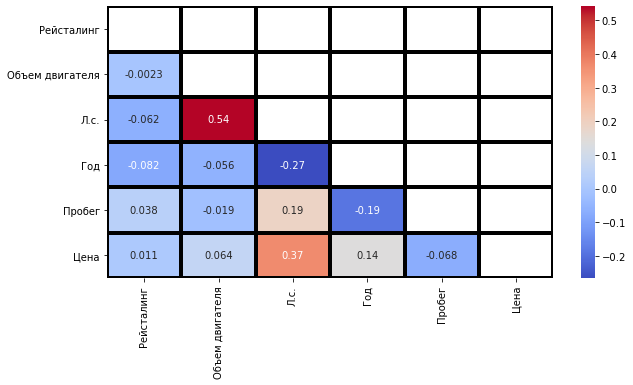

In [730]:
# корреляция данных без пропущенных значений
cor = dt.dropna(how = 'any', inplace = False)
fig, ax = plt.subplots(figsize=(10, 5))
mask_matrix = np.triu(cor.corr())
sns.heatmap(cor.corr(), annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', mask=mask_matrix)

Корреляции между числовыми данными обнаружена между "Объем двигателя" и "Л.с." 0.54, а также между "Ценой" и "Л.с." 0.37. Однако, я считаю, что данные признаки не стоит убирать, так как пользователь зачастую ищет по "Объем двигателя" и "Л.с." одновременно. 

In [731]:
categorical_columns= [column for column in dt.columns if dt[column].dtype == 'object']
numerical_columns = [column for column in dt.columns if dt[column].dtype != 'object']

In [732]:
categorical_columns

['Марка', 'Модель', 'Топливо', 'К\\п', 'Кузов', 'Привод', 'Цвет']

In [733]:
dt_new = dt.drop('Цена', axis = 1)

In [734]:
label_encoder = LabelEncoder()

for col in categorical_columns:
    if dt_new[col].nunique() <= 4:
        col_encoder = pd.Series(label_encoder.fit_transform(dt_new[col]))
        dt_new[col] = col_encoder
dt_new.head()

,Марка,Модель,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Кузов,Привод,Цвет,Год,Пробег
0,Peugeot,308 I,1,1.6,120.0,0,0,хэтчбек 5 дв.,1,белый,2012,149674.0
1,Chevrolet,Aveo I,1,1.2,84.0,0,2,седан,1,чёрный,2011,148900.0
2,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,0,2,внедорожник 3 дв.,2,белый,2014,33950.0
3,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,0,2,внедорожник 3 дв.,2,зелёный,2015,53500.0
4,LADA,(ВАЗ) 2104,0,1.6,74.0,0,2,универсал 5 дв.,0,синий,2011,43000.0


In [735]:
dt

,Марка,Модель,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Кузов,Привод,Цвет,Год,Пробег,Цена
0,Peugeot,308 I,1,1.6,120.0,Бензин,автомат,хэтчбек 5 дв.,передний,белый,2012,149674.0,439000.0
1,Chevrolet,Aveo I,1,1.2,84.0,Бензин,механика,седан,передний,чёрный,2011,148900.0,289000.0
2,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,Бензин,механика,внедорожник 3 дв.,полный,белый,2014,33950.0,370000.0
3,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,Бензин,механика,внедорожник 3 дв.,полный,зелёный,2015,53500.0,335000.0
4,LADA,(ВАЗ) 2104,0,1.6,74.0,Бензин,механика,универсал 5 дв.,задний,синий,2011,43000.0,245000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3634,Chevrolet,Niva I,1,1.7,80.0,Бензин,механика,внедорожник 5 дв.,полный,серебристый,2016,56000.0,500000.0
3635,Nissan,Almera III (G15),0,1.6,102.0,Бензин,автомат,седан,передний,белый,2017,127000.0,500000.0
3636,Datsun,on-DO I,0,1.6,87.0,Бензин,механика,седан,передний,чёрный,2015,50000.0,345000.0
3637,Chevrolet,Aveo II,0,1.6,115.0,Бензин,механика,седан,передний,чёрный,2012,131000.0,450000.0


In [736]:
dt_new.dtypes

Марка               object
Модель              object
Рейсталинг           int64
Объем двигателя    float64
Л.с.               float64
Топливо              int32
К\п                  int32
Кузов               object
Привод               int32
Цвет                object
Год                  int64
Пробег             float64
dtype: object

In [737]:
OHE = OneHotEncoder(sparse=False) 

for col in categorical_columns:
    if dt_new[col].nunique() > 4:
        col_encoder = pd.DataFrame(OHE.fit_transform(dt_new[col].values.reshape(-1, 1)))
        dt_new = pd.concat([col_encoder, dt_new], axis = 1)
        dt_new.drop(col, axis = 1, inplace = True)
dt_new.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Привод,Год,Пробег
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,1.6,120.0,0,0,1,2012,149674.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,1.2,84.0,0,2,1,2011,148900.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,1.7,83.0,0,2,2,2014,33950.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,1.7,83.0,0,2,2,2015,53500.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1.6,74.0,0,2,0,2011,43000.0


In [738]:
dt_new.tail(10) # данные при переводе из численных значений в категориальные сконкотенатились верно

,0,1,2,3,4,5,6,7,8,9,...,43,44,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Привод,Год,Пробег
3629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,1.4,101.0,0,2,1,2010,252900.0
3630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1.6,105.0,0,2,1,2012,418286.0
3631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1.6,140.0,0,0,1,2010,149000.0
3632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,1.6,124.0,0,2,1,2014,260000.0
3633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1.6,103.0,0,0,1,2012,230000.0
3634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,1.7,80.0,0,2,2,2016,56000.0
3635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1.6,102.0,0,0,1,2017,127000.0
3636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1.6,87.0,0,2,1,2015,50000.0
3637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1.6,115.0,0,2,1,2012,131000.0
3638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,1.8,140.0,0,3,1,2010,195000.0


In [739]:
scaler = MinMaxScaler(feature_range = (0, 1))
for col in numerical_columns:
    if col != 'Пробег' and col != 'Цена':
        dt_new[col] = scaler.fit_transform(dt_new[col].values.reshape(-1, 1))
dt_new.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Привод,Год,Пробег
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.36,0.415205,0,0,1,0.181818,149674.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.20,0.204678,0,2,1,0.090909,148900.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.40,0.198830,0,2,2,0.363636,33950.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.40,0.198830,0,2,2,0.454545,53500.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.36,0.146199,0,2,0,0.090909,43000.0


In [740]:
# вставляем пропущенные значения в пробег автомобиля на основе корреляции данных
bool_series = pd.notnull(dt_new["Пробег"])

pred = dt_new[[col for col in dt_new.columns if col != 'Пробег' and col != 'Цена']][bool_series]
target = dt_new['Пробег'].dropna()

holdout = dt_new[[col for col in dt_new.columns if col != 'Пробег' and col != 'Цена']][dt_new['Пробег'].isnull()]

In [741]:
%%time
model_knn = KNeighborsRegressor(n_neighbors=10) #Задаем количество соседий на угад
knn_params = {'n_neighbors': list(range(3, 11)) + list(range(20, 31))}
model_knn_grid = GridSearchCV(model_knn, knn_params,
                              cv = 5,
                              n_jobs = -1, 
                              verbose = False)
model_knn_grid.fit(pred, target)
knn_pred = model_knn_grid.predict(holdout)

print("Лучшее качество обучение = {}".format(model_knn_grid.best_score_))
print("Оптимальное количество соседей = {}".format(model_knn_grid.best_params_))

Лучшее качество обучение = 0.15301261015736892
Оптимальное количество соседей = {'n_neighbors': 29}
Wall time: 1min 48s


In [742]:
knn_pred = knn_pred.round(0)
value = list()
nan_ind = dt_new['Пробег'][dt_new['Пробег'].isnull()].index
k = 0

for ind, val in enumerate(dt_new['Пробег']):
    if ind in nan_ind:
        value.append(knn_pred[k])
        k += 1
    else:
        value.append(val)

In [743]:
dt_new['Пробег'] = value
dt_new.isnull().sum()

0          0
1          0
2          0
3          0
4          0
          ..
Топливо    0
К\п        0
Привод     0
Год        0
Пробег     0
Length: 347, dtype: int64

Теперь поле пробег заполнено полностью

In [744]:
dt['Пробег'] = dt_new['Пробег']
dt.isnull().sum()

Марка                0
Модель               0
Рейсталинг           0
Объем двигателя      0
Л.с.                 0
Топливо              0
К\п                  0
Кузов                0
Привод               0
Цвет                 0
Год                  0
Пробег               0
Цена               486
dtype: int64

На мой взгляд значения, которые пропущены в полен Цена, можно отложить и на них проверить, как обучилась наша модель.

In [325]:
dt.shape

(3639, 13)

In [368]:
dt_not_nan = dt.dropna(how = 'any')
print(dt_not_nan.shape)
dt_not_nan.head()

(3153, 13)


,Марка,Модель,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Кузов,Привод,Цвет,Год,Пробег,Цена
0,Peugeot,308 I,1,1.6,120.0,Бензин,автомат,хэтчбек 5 дв.,передний,белый,2012,149674.0,439000.0
1,Chevrolet,Aveo I,1,1.2,84.0,Бензин,механика,седан,передний,чёрный,2011,148900.0,289000.0
2,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,Бензин,механика,внедорожник 3 дв.,полный,белый,2014,33950.0,370000.0
3,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,Бензин,механика,внедорожник 3 дв.,полный,зелёный,2015,53500.0,335000.0
4,LADA,(ВАЗ) 2104,0,1.6,74.0,Бензин,механика,универсал 5 дв.,задний,синий,2011,43000.0,245000.0


In [370]:
dt_not_nan.index = [ind for ind, val in enumerate(list(dt_not_nan.index))]
dt_not_nan

,Марка,Модель,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Кузов,Привод,Цвет,Год,Пробег,Цена
0,Peugeot,308 I,1,1.6,120.0,Бензин,автомат,хэтчбек 5 дв.,передний,белый,2012,149674.0,439000.0
1,Chevrolet,Aveo I,1,1.2,84.0,Бензин,механика,седан,передний,чёрный,2011,148900.0,289000.0
2,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,Бензин,механика,внедорожник 3 дв.,полный,белый,2014,33950.0,370000.0
3,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,Бензин,механика,внедорожник 3 дв.,полный,зелёный,2015,53500.0,335000.0
4,LADA,(ВАЗ) 2104,0,1.6,74.0,Бензин,механика,универсал 5 дв.,задний,синий,2011,43000.0,245000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3148,Chevrolet,Niva I,1,1.7,80.0,Бензин,механика,внедорожник 5 дв.,полный,серебристый,2016,56000.0,500000.0
3149,Nissan,Almera III (G15),0,1.6,102.0,Бензин,автомат,седан,передний,белый,2017,127000.0,500000.0
3150,Datsun,on-DO I,0,1.6,87.0,Бензин,механика,седан,передний,чёрный,2015,50000.0,345000.0
3151,Chevrolet,Aveo II,0,1.6,115.0,Бензин,механика,седан,передний,чёрный,2012,131000.0,450000.0


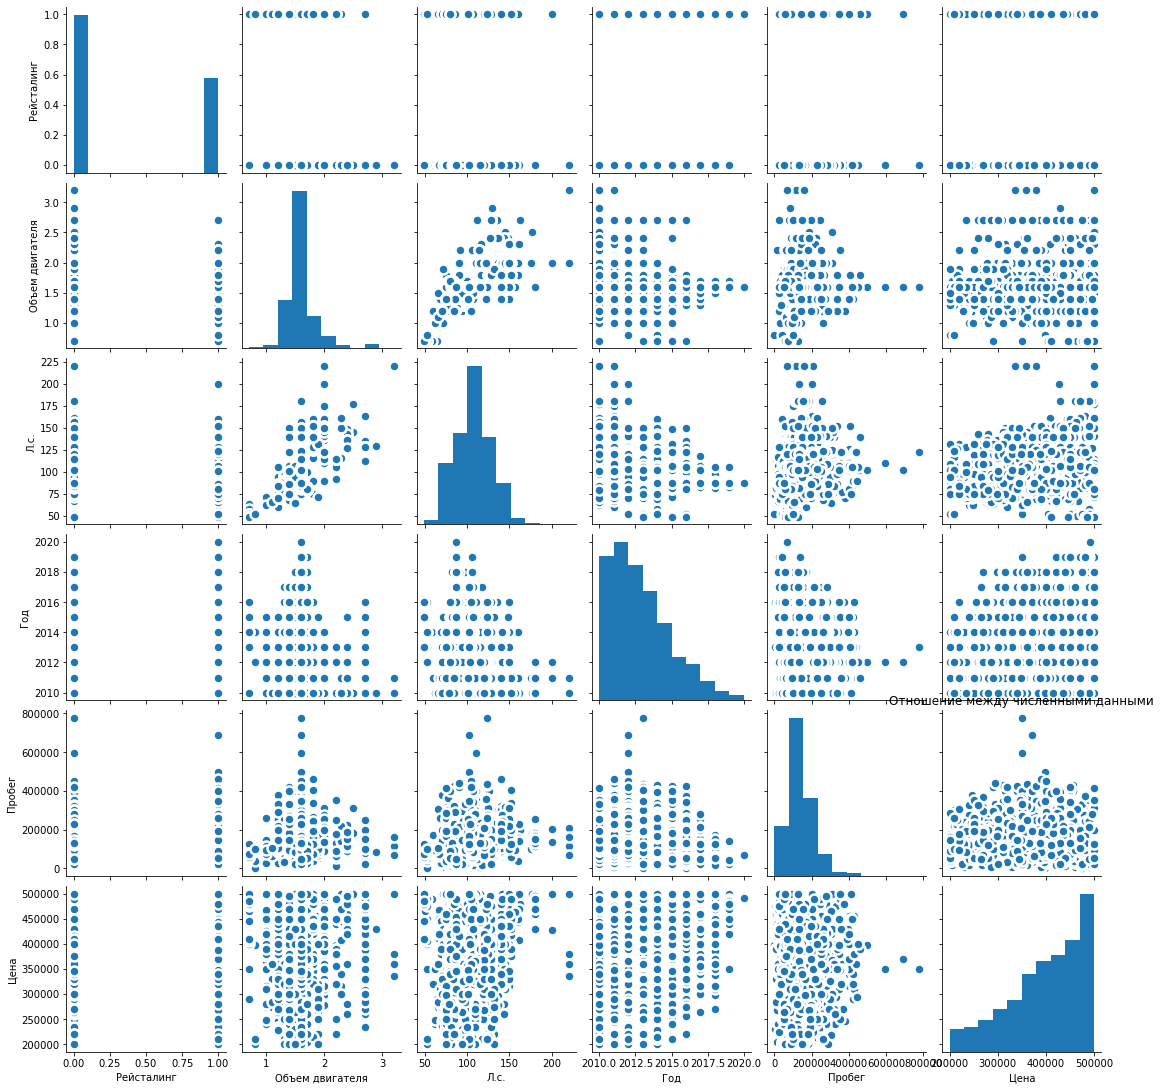

In [371]:
sns.pairplot(dt_not_nan, kind="scatter", plot_kws=dict(s=100, edgecolor="white", linewidth=2.5))
plt.title('Отношение между численными данными')
plt.show()

Корреляция наблюдается только, как говорили выше между Объемом двигателя и Л.с., Л.с. и ценой. Это подтферждает матрица корреляции (см. ниже)

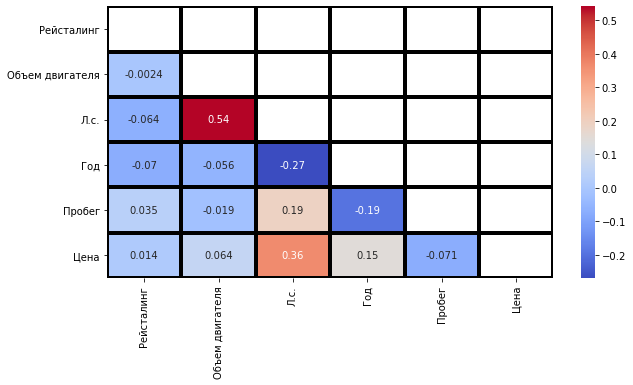

In [372]:
# корреляция данных без пропущенных значений
fig, ax = plt.subplots(figsize=(10, 5))
mask_matrix = np.triu(dt_not_nan.corr())
sns.heatmap(dt_not_nan.corr(), annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', mask=mask_matrix)

Text(0.5, 1.0, 'Распределение цен автомобилей')

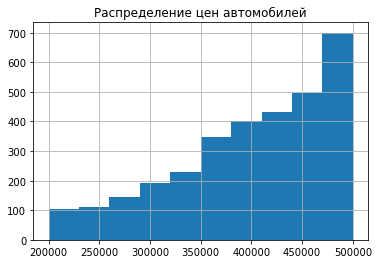

In [373]:
dt_not_nan['Цена'].hist()
plt.title('Распределение цен автомобилей')

Цены автомобилей не имеют нормального распределения, они смещены в сторону большей цены. Этот факт предполагался, так как в фильтре были выбрано автомобили, начиная с 2010 года от цены 200000 до 500000, а как известно чем меньше лет автомобилю и пробег, тем выше его цена, то есть можно сделать вывод, что в спарсенных данных большинство автомобилей имеют недалекий год выпуска и относительно небольшой пробег. 
- Данное распределение во многом зависит от поставленного пользователем фильтра

In [374]:
def box_two(col1, df, text, col2 = 'Цена'):
    plt.figure(figsize=(16, 6))
    sns.boxplot(x=col1, y=col2, data=df, linewidth=3)
    plt.title('Распределение ' + text + ' от Цены автомобиля', fontsize = 15)
    plt.grid(True)

In [375]:
txt_title = ['марки',
             'модели',
             'вида топлива',
             'К/п',
             'кузова',
             'типа привода',
             'цвета']
categorical_columns

['Марка', 'Модель', 'Топливо', 'К\\п', 'Кузов', 'Привод', 'Цвет']

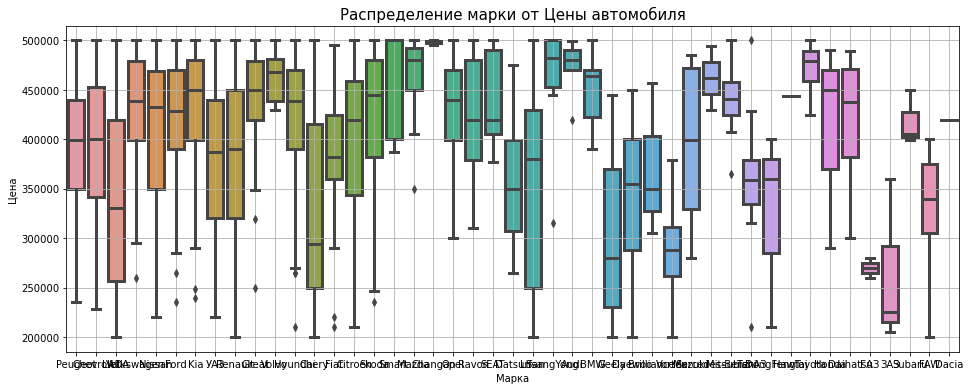

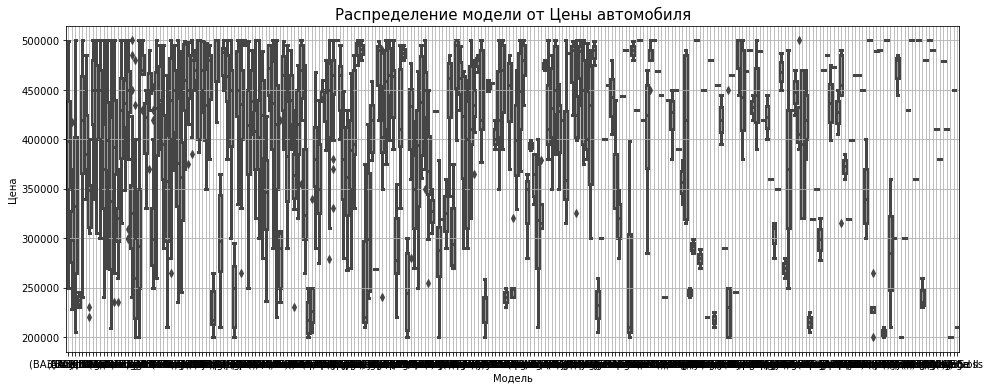

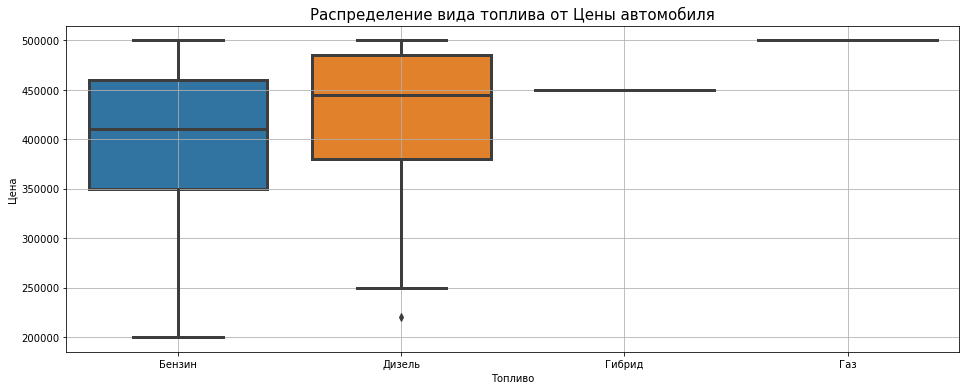

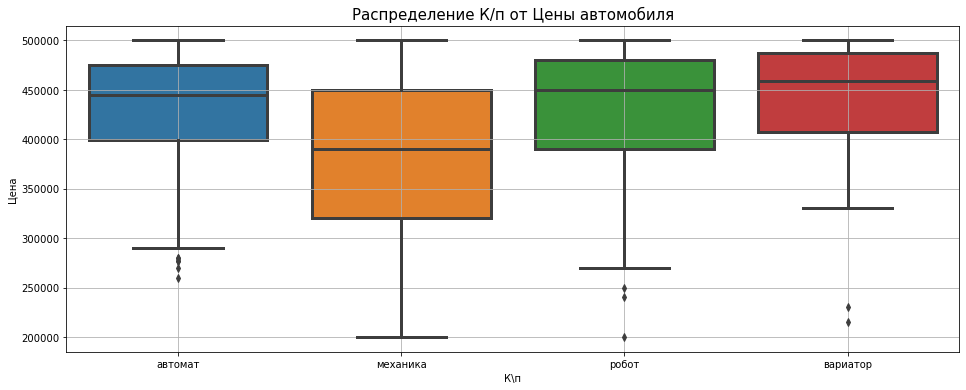

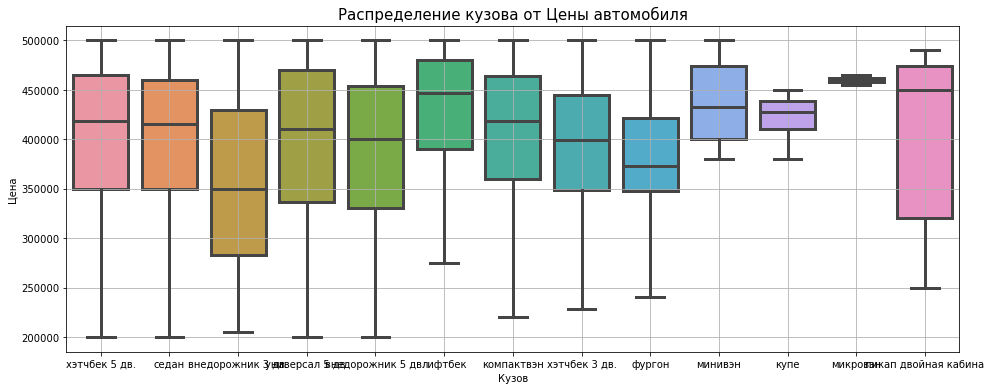

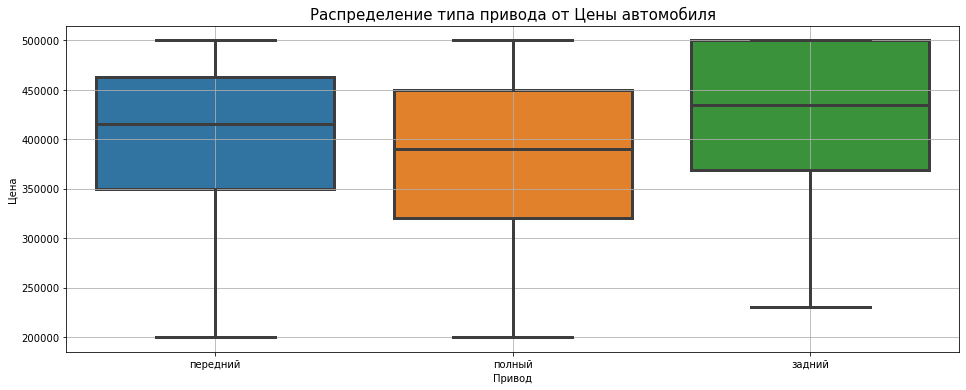

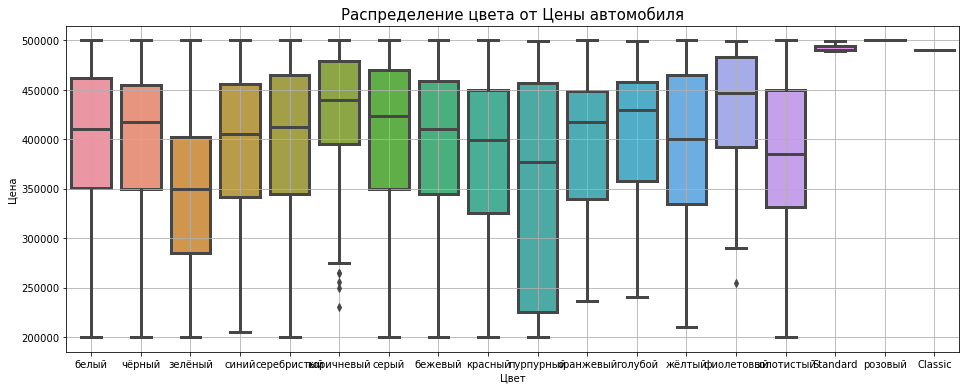

In [376]:
for ind, col in enumerate(categorical_columns):
    box_two(col, dt_not_nan, txt_title[ind])

В представленных данных выбрасов практически нет или их незначительное количество, за искюлчением модели автомобиля, так как самих моделей очень много и сами модели находятся в различном состоянии в зависимости от того, как ими пользовались. 
По представленным диаграмам можно предположить примерную цену автомобиля в зависимости от различных категориальных праметров.

# Перевод категориальных в численные

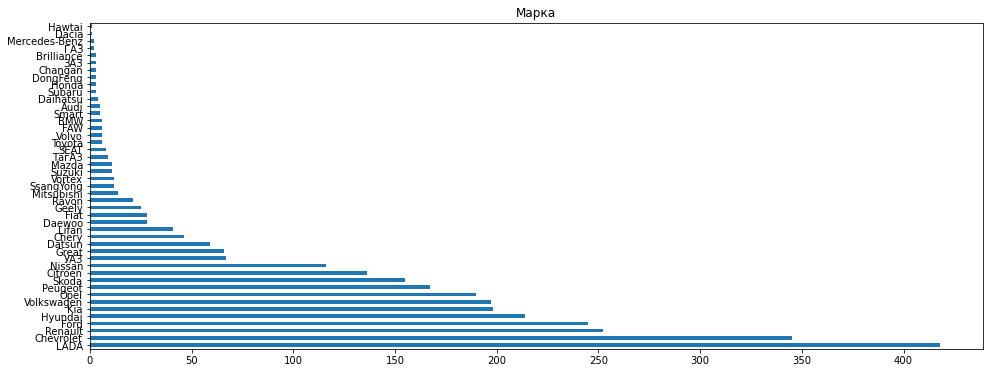

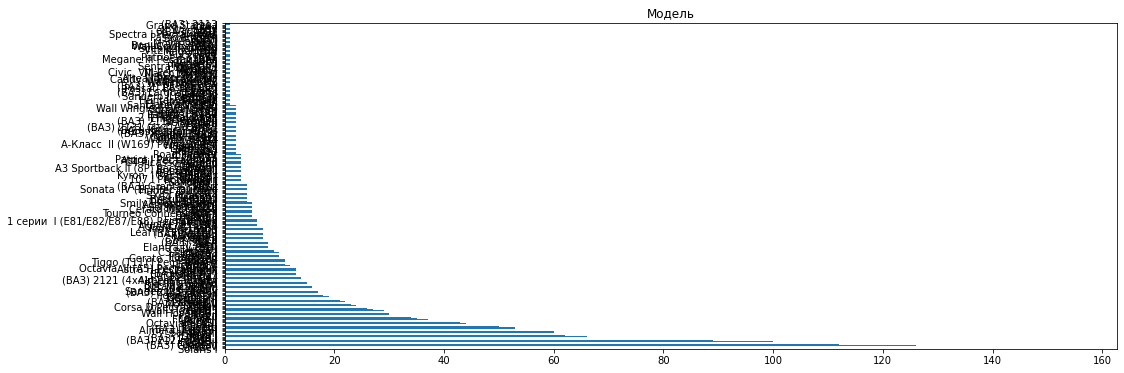

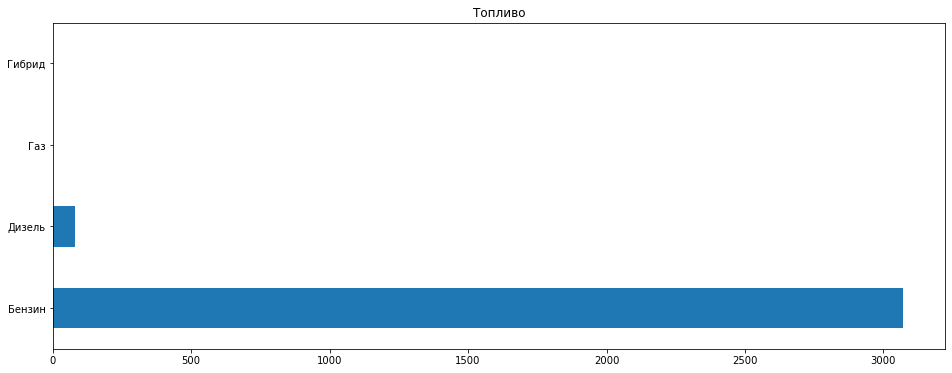

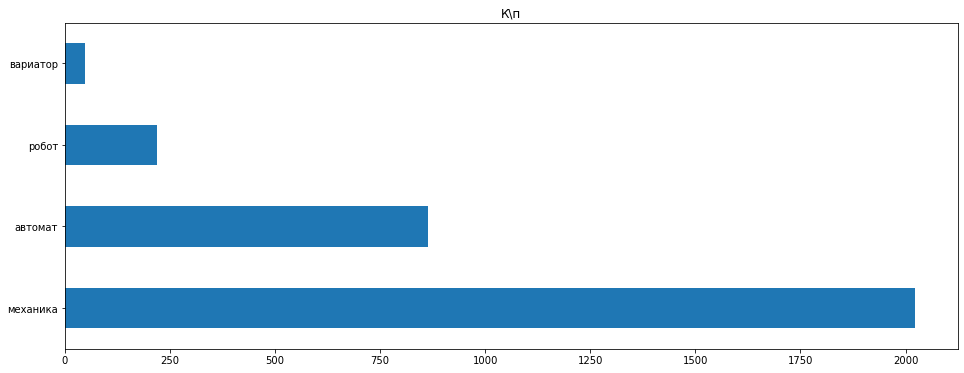

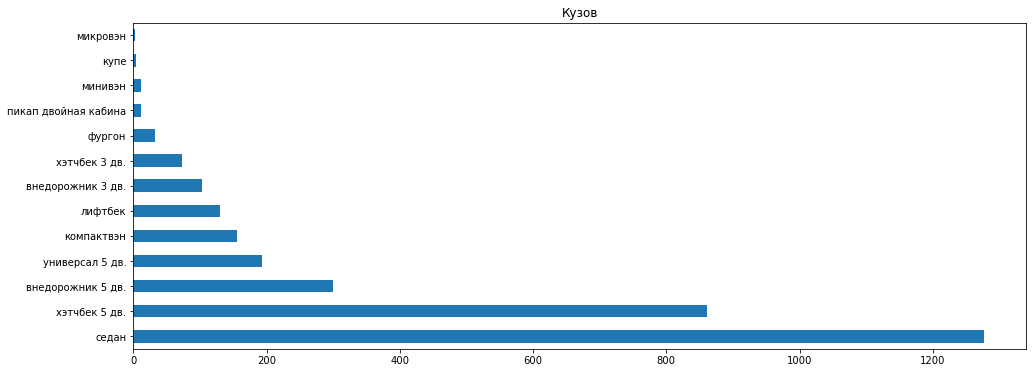

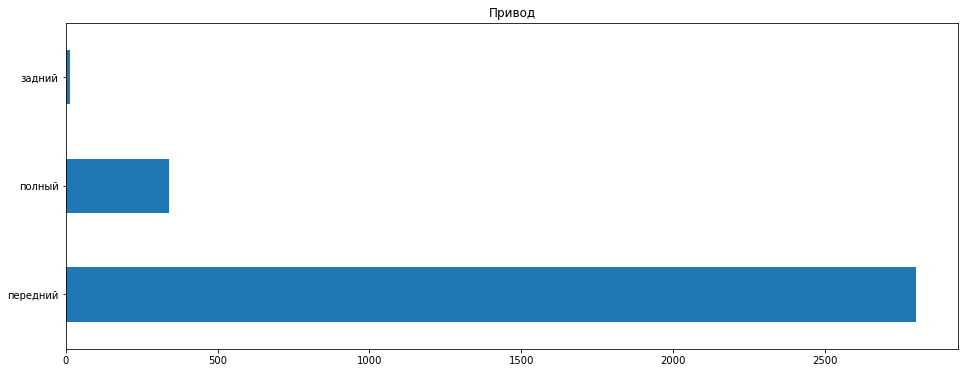

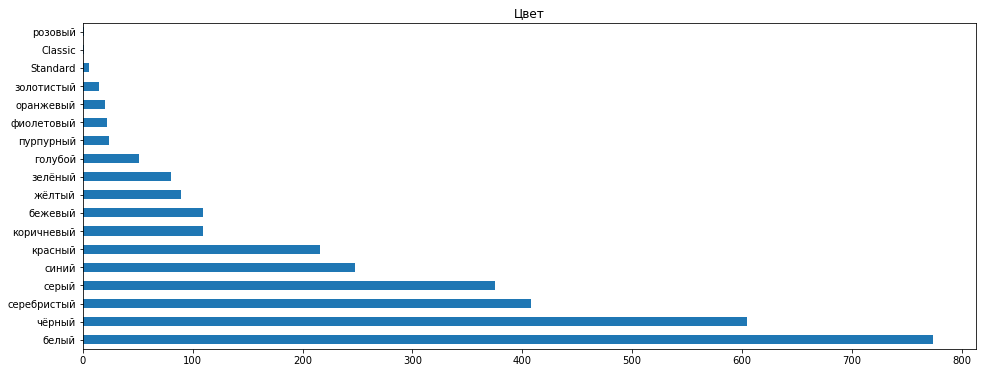

In [377]:
for col in categorical_columns:
    plt.figure(figsize=(16, 6))
    dt_not_nan[col].value_counts().plot.barh()
    plt.title(col)

По данным графикам, можно увидеть сколько автомобилей представлено в завиимости от того или иного признака

In [378]:
label_encoder = LabelEncoder()

for col in categorical_columns:
    if dt_not_nan[col].nunique() <= 4:
        col_encoder = pd.Series(label_encoder.fit_transform(dt_not_nan[col]))
        dt_not_nan[col] = col_encoder
dt_not_nan.head()

,Марка,Модель,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Кузов,Привод,Цвет,Год,Пробег,Цена
0,Peugeot,308 I,1,1.6,120.0,0,0,хэтчбек 5 дв.,1,белый,2012,149674.0,439000.0
1,Chevrolet,Aveo I,1,1.2,84.0,0,2,седан,1,чёрный,2011,148900.0,289000.0
2,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,0,2,внедорожник 3 дв.,2,белый,2014,33950.0,370000.0
3,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,0,2,внедорожник 3 дв.,2,зелёный,2015,53500.0,335000.0
4,LADA,(ВАЗ) 2104,0,1.6,74.0,0,2,универсал 5 дв.,0,синий,2011,43000.0,245000.0


In [379]:
dt_not_nan

,Марка,Модель,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Кузов,Привод,Цвет,Год,Пробег,Цена
0,Peugeot,308 I,1,1.6,120.0,0,0,хэтчбек 5 дв.,1,белый,2012,149674.0,439000.0
1,Chevrolet,Aveo I,1,1.2,84.0,0,2,седан,1,чёрный,2011,148900.0,289000.0
2,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,0,2,внедорожник 3 дв.,2,белый,2014,33950.0,370000.0
3,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,0,2,внедорожник 3 дв.,2,зелёный,2015,53500.0,335000.0
4,LADA,(ВАЗ) 2104,0,1.6,74.0,0,2,универсал 5 дв.,0,синий,2011,43000.0,245000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3148,Chevrolet,Niva I,1,1.7,80.0,0,2,внедорожник 5 дв.,2,серебристый,2016,56000.0,500000.0
3149,Nissan,Almera III (G15),0,1.6,102.0,0,0,седан,1,белый,2017,127000.0,500000.0
3150,Datsun,on-DO I,0,1.6,87.0,0,2,седан,1,чёрный,2015,50000.0,345000.0
3151,Chevrolet,Aveo II,0,1.6,115.0,0,2,седан,1,чёрный,2012,131000.0,450000.0


In [380]:
OHE = OneHotEncoder(sparse=False) 

for col in categorical_columns:
    if dt_not_nan[col].nunique() > 4:
        col_encoder = pd.DataFrame(OHE.fit_transform(dt_not_nan[col].values.reshape(-1, 1)))
        dt_not_nan = pd.concat([col_encoder, dt_not_nan], axis = 1)
        dt_not_nan.drop(col, axis = 1, inplace = True)
dt_not_nan.head()

,0,1,2,3,4,5,6,7,8,9,...,44,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Привод,Год,Пробег,Цена
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,1.6,120.0,0,0,1,2012,149674.0,439000.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,1.2,84.0,0,2,1,2011,148900.0,289000.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,1.7,83.0,0,2,2,2014,33950.0,370000.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1,1.7,83.0,0,2,2,2015,53500.0,335000.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.6,74.0,0,2,0,2011,43000.0,245000.0


In [381]:
dt_not_nan.tail()

,0,1,2,3,4,5,6,7,8,9,...,44,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Привод,Год,Пробег,Цена
3148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,1.7,80.0,0,2,2,2016,56000.0,500000.0
3149,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.6,102.0,0,0,1,2017,127000.0,500000.0
3150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.6,87.0,0,2,1,2015,50000.0,345000.0
3151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.6,115.0,0,2,1,2012,131000.0,450000.0
3152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,1.8,140.0,0,3,1,2010,195000.0,435000.0


In [382]:
dt_not_nan.isnull().sum()

0         0
1         0
2         0
3         0
4         0
         ..
К\п       0
Привод    0
Год       0
Пробег    0
Цена      0
Length: 338, dtype: int64

# Стандартизация

In [396]:
scaler = MinMaxScaler(feature_range = (0, 1))
for col in numerical_columns:
    if col != 'Цена':
        dt_not_nan[col] = scaler.fit_transform(dt_not_nan[col].values.reshape(-1, 1))
dt_not_nan.head()

,0,1,2,3,4,5,6,7,8,9,...,44,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Привод,Год,Пробег,Цена
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.36,0.415205,0,0,1,0.2,0.192333,439000.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.20,0.204678,0,2,1,0.1,0.191338,289000.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.40,0.198830,0,2,2,0.4,0.043526,370000.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.40,0.198830,0,2,2,0.5,0.068665,335000.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.36,0.146199,0,2,0,0.1,0.055163,245000.0


In [398]:
dt_not_nan.shape

(3153, 338)

# Кластерный анализ

Кластеризация будет проводиться на основе метода k-means

In [408]:
K = range(1, 19)
models = [KMeans(n_clusters=k, random_state=42).fit(dt_not_nan.iloc[:, :-1]) for k in K]
dist = [model.inertia_ for model in models]

In [409]:
dist

[16049.018190679722,
 13227.38317355172,
 12486.677247140997,
 11794.911891403086,
 11274.716132497799,
 10912.219992842973,
 10597.104842232613,
 10248.329668818444,
 10069.123574408137,
 9735.188034434603,
 9605.793909162829,
 9470.900397771818,
 9315.697805167725,
 9142.484355583625,
 8969.362876817171,
 8878.628131587004,
 8757.372109519069,
 8662.503475336971]

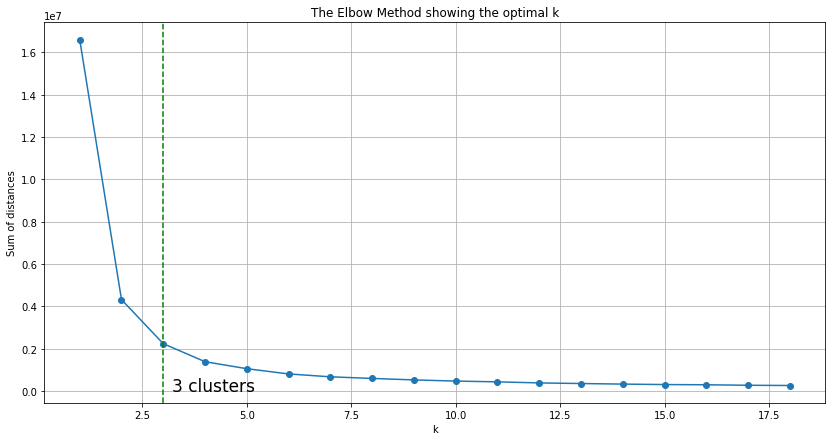

In [815]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.axvline(3, c='g', linestyle='dashed')
plt.text(3.2, 14000, '3 clusters', size = 17)
plt.title('The Elbow Method showing the optimal k')
plt.grid(True)
plt.show()

Неирархический метод k-mens показывает, что оптимальное кол-во кластеров явялется 3

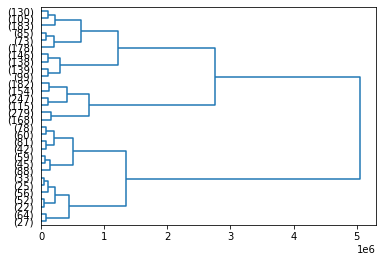

In [413]:
# дендограмма
link = linkage(dt_not_nan, 'ward', 'euclidean')
dend = dendrogram(link,
                  labels = dt_not_nan.index.to_list(),
                  truncate_mode='lastp', 
                  color_threshold=5,
                  orientation = "right",
                  leaf_rotation=0.)

Как и предполагалось будет использованно 3 кластера

In [414]:
model_opt = KMeans(n_clusters = 3, random_state = 42)
model_opt.fit(dt_not_nan)
model_opt.labels_ # Метод опеределения кластера для каждого экзмепляра

array([2, 1, 0, ..., 0, 2, 2])

In [418]:
dt_not_nan['cluster'] = model_opt.labels_
dt_not_nan.head(10)

,0,1,2,3,4,5,6,7,8,9,...,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Привод,Год,Пробег,Цена,cluster
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.36,0.415205,0,0,1,0.2,0.192333,439000.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.20,0.204678,0,2,1,0.1,0.191338,289000.0,1
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.40,0.198830,0,2,2,0.4,0.043526,370000.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.40,0.198830,0,2,2,0.5,0.068665,335000.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.36,0.146199,0,2,0,0.1,0.055163,245000.0,1
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.36,0.327485,0,2,1,0.6,0.091168,499000.0,2
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.36,0.309942,0,2,1,0.0,0.180623,340000.0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.36,0.339181,0,2,1,0.2,0.095025,349000.0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.36,0.444444,0,2,1,0.1,0.133444,432000.0,2
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.36,0.350877,0,0,1,0.4,0.142603,499000.0,2


In [419]:
dt_not_nan.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,...,44,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Привод,Год,Пробег,Цена
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.036937,0.274775,0.012613,0.031532,0.026126,0.005405,0.027027,0.071171,...,0.026126,0.404505,0.361192,0.328796,0.056757,1.525225,1.105405,0.231532,0.191158,379589.807207
1,0.000000,0.000000,0.032468,0.196429,0.012987,0.029221,0.055195,0.004870,0.022727,0.090909,...,0.030844,0.344156,0.353961,0.264449,0.048701,1.900974,1.144481,0.193019,0.183046,272673.425325
2,0.000701,0.004205,0.033637,0.243868,0.020322,0.025228,0.011913,0.004205,0.045550,0.056762,...,0.013315,0.364401,0.370526,0.380744,0.107218,1.323756,1.081990,0.261177,0.170673,466497.058865


In [420]:
dt_not_nan.groupby('cluster').size()

cluster
0    1110
1     616
2    1427
dtype: int64

Самым многочисленным является 3 кластер

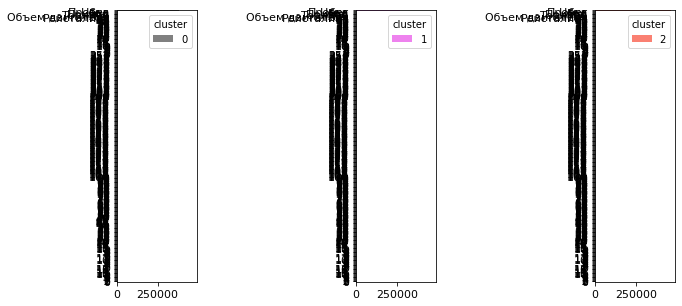

In [422]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True)
fig.set_size_inches(10, 5)
plt.subplots_adjust(wspace = 2)
k = 0
c = ['grey', 'violet', 'salmon', 'skyblue', 'orange']
for j in range(3):
    ax = axs[j]
    k += 1
    dt_not_nan[dt_not_nan.cluster == k-1].groupby('cluster').mean().T.plot.barh(ax = ax, color = c[k-1])
    ax.tick_params(labelsize = 11)

Попробуем закодировать через LabelEncoder

In [445]:
dt.dropna(how = 'any').isnull().sum()

Марка              0
Модель             0
Рейсталинг         0
Объем двигателя    0
Л.с.               0
Топливо            0
К\п                0
Кузов              0
Привод             0
Цвет               0
Год                0
Пробег             0
Цена               0
dtype: int64

In [488]:
dt_not_nan_new = dt.dropna(how = 'any')
print(dt_not_nan_new.shape)
dt_not_nan_new.index = [ind for ind, val in enumerate(list(dt_not_nan_new.index))]
dt_not_nan_new

(3153, 13)


,Марка,Модель,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Кузов,Привод,Цвет,Год,Пробег,Цена
0,Peugeot,308 I,1,1.6,120.0,Бензин,автомат,хэтчбек 5 дв.,передний,белый,2012,149674.0,439000.0
1,Chevrolet,Aveo I,1,1.2,84.0,Бензин,механика,седан,передний,чёрный,2011,148900.0,289000.0
2,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,Бензин,механика,внедорожник 3 дв.,полный,белый,2014,33950.0,370000.0
3,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,Бензин,механика,внедорожник 3 дв.,полный,зелёный,2015,53500.0,335000.0
4,LADA,(ВАЗ) 2104,0,1.6,74.0,Бензин,механика,универсал 5 дв.,задний,синий,2011,43000.0,245000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3148,Chevrolet,Niva I,1,1.7,80.0,Бензин,механика,внедорожник 5 дв.,полный,серебристый,2016,56000.0,500000.0
3149,Nissan,Almera III (G15),0,1.6,102.0,Бензин,автомат,седан,передний,белый,2017,127000.0,500000.0
3150,Datsun,on-DO I,0,1.6,87.0,Бензин,механика,седан,передний,чёрный,2015,50000.0,345000.0
3151,Chevrolet,Aveo II,0,1.6,115.0,Бензин,механика,седан,передний,чёрный,2012,131000.0,450000.0


In [489]:
dt_not_nan_new.isnull().sum()

Марка              0
Модель             0
Рейсталинг         0
Объем двигателя    0
Л.с.               0
Топливо            0
К\п                0
Кузов              0
Привод             0
Цвет               0
Год                0
Пробег             0
Цена               0
dtype: int64

In [490]:
categorical_columns= [column for column in dt_not_nan_new.columns if dt_not_nan_new[column].dtype == 'object']
numerical_columns = [column for column in dt_not_nan_new.columns if dt_not_nan_new[column].dtype != 'object']

In [491]:
categorical_columns

['Марка', 'Модель', 'Топливо', 'К\\п', 'Кузов', 'Привод', 'Цвет']

In [492]:
encoder = LabelEncoder()

for col in categorical_columns:
    col_encoder = pd.Series(encoder.fit_transform(dt_not_nan_new[col]))
    dt_not_nan_new[col] = col_encoder
dt_not_nan_new.head()

,Марка,Модель,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Кузов,Привод,Цвет,Год,Пробег,Цена
0,28,30,1,1.6,120.0,0,0,12,1,3,2012,149674.0,439000.0
1,5,50,1,1.2,84.0,0,2,8,1,17,2011,148900.0,289000.0
2,21,7,1,1.7,83.0,0,2,0,2,3,2014,33950.0,370000.0
3,21,7,1,1.7,83.0,0,2,0,2,6,2015,53500.0,335000.0
4,21,0,0,1.6,74.0,0,2,9,0,15,2011,43000.0,245000.0


In [493]:
dt_not_nan_new

,Марка,Модель,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Кузов,Привод,Цвет,Год,Пробег,Цена
0,28,30,1,1.6,120.0,0,0,12,1,3,2012,149674.0,439000.0
1,5,50,1,1.2,84.0,0,2,8,1,17,2011,148900.0,289000.0
2,21,7,1,1.7,83.0,0,2,0,2,3,2014,33950.0,370000.0
3,21,7,1,1.7,83.0,0,2,0,2,6,2015,53500.0,335000.0
4,21,0,0,1.6,74.0,0,2,9,0,15,2011,43000.0,245000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3148,5,153,1,1.7,80.0,0,2,1,2,13,2016,56000.0,500000.0
3149,26,43,0,1.6,102.0,0,0,8,1,3,2017,127000.0,500000.0
3150,10,252,0,1.6,87.0,0,2,8,1,17,2015,50000.0,345000.0
3151,5,51,0,1.6,115.0,0,2,8,1,17,2012,131000.0,450000.0


In [494]:
dt_not_nan_new.isnull().sum()

Марка              0
Модель             0
Рейсталинг         0
Объем двигателя    0
Л.с.               0
Топливо            0
К\п                0
Кузов              0
Привод             0
Цвет               0
Год                0
Пробег             0
Цена               0
dtype: int64

In [495]:
scaler = MinMaxScaler(feature_range = (0, 1))
for col in numerical_columns:
    #if col != 'Цена':
    dt_not_nan_new[col] = scaler.fit_transform(dt_not_nan_new[col].values.reshape(-1, 1))
dt_not_nan_new.head()

,Марка,Модель,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Кузов,Привод,Цвет,Год,Пробег,Цена
0,28,30,1.0,0.36,0.415205,0,0,12,1,3,0.2,0.192333,0.796667
1,5,50,1.0,0.20,0.204678,0,2,8,1,17,0.1,0.191338,0.296667
2,21,7,1.0,0.40,0.198830,0,2,0,2,3,0.4,0.043526,0.566667
3,21,7,1.0,0.40,0.198830,0,2,0,2,6,0.5,0.068665,0.450000
4,21,0,0.0,0.36,0.146199,0,2,9,0,15,0.1,0.055163,0.150000


In [496]:
K = range(1, 19)
models = [KMeans(n_clusters=k, random_state=42).fit(dt_not_nan_new.iloc[:, :-1]) for k in K]
dist = [model.inertia_ for model in models]

In [497]:
dist

[16599049.693103457,
 4315841.198091926,
 2233967.235455404,
 1382022.5455448763,
 1051357.9562379762,
 804029.26415813,
 668335.1717937198,
 591894.9054952916,
 522137.92216663307,
 466833.16937114764,
 430175.0546566078,
 379796.8016801278,
 350977.1253271511,
 324109.43677146005,
 302745.38310346025,
 291953.4542090564,
 268986.331709102,
 257661.87736211665]

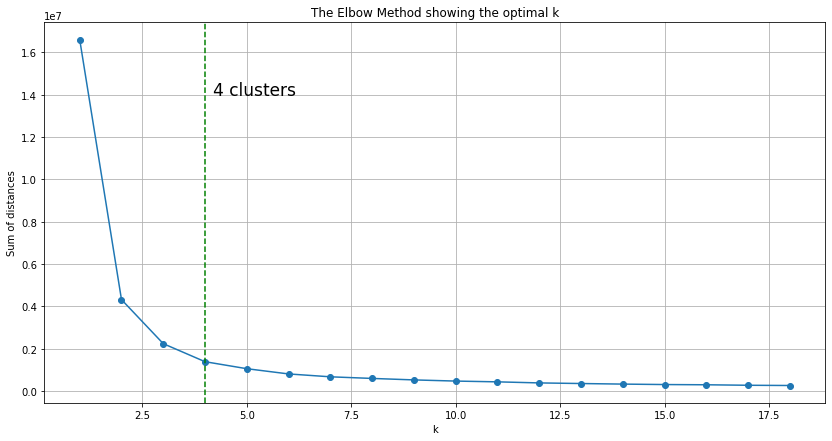

In [816]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.axvline(4, c='g', linestyle='dashed')
plt.text(4.2, 14000000, '4 clusters', size = 17)
plt.title('The Elbow Method showing the optimal k')
plt.grid(True)
plt.show()

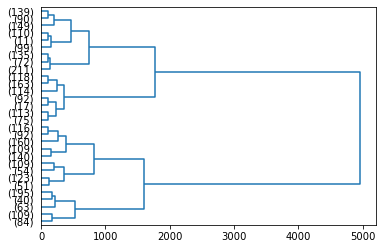

In [501]:
# дендограмма
link = linkage(dt_not_nan_new, 'ward', 'euclidean')
dend = dendrogram(link,
                  labels = dt_not_nan.index.to_list(),
                  truncate_mode='lastp', 
                  color_threshold=5,
                  orientation = "right",
                  leaf_rotation=0.)

 При кодировки всех категориальных признаков через LabelEncoder получается 4 кластера

In [502]:
model_opt = KMeans(n_clusters = 4, random_state = 42)
model_opt.fit(dt_not_nan_new)
model_opt.labels_ # Метод опеределения кластера для каждого экзмепляра

array([2, 2, 2, ..., 1, 2, 1])

In [503]:
dt_not_nan_new['cluster'] = model_opt.labels_
dt_not_nan_new.head()

,Марка,Модель,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Кузов,Привод,Цвет,Год,Пробег,Цена,cluster
0,28,30,1.0,0.36,0.415205,0,0,12,1,3,0.2,0.192333,0.796667,2
1,5,50,1.0,0.20,0.204678,0,2,8,1,17,0.1,0.191338,0.296667,2
2,21,7,1.0,0.40,0.198830,0,2,0,2,3,0.4,0.043526,0.566667,2
3,21,7,1.0,0.40,0.198830,0,2,0,2,6,0.5,0.068665,0.450000,2
4,21,0,0.0,0.36,0.146199,0,2,9,0,15,0.1,0.055163,0.150000,2


In [504]:
dt_not_nan_new.groupby('cluster').mean()

,Марка,Модель,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Кузов,Привод,Цвет,Год,Пробег,Цена
cluster,,,,,,,,,,,,,
0,15.822599,93.796610,0.411299,0.358870,0.365646,0.046328,1.459887,9.013559,1.014689,10.421469,0.168362,0.195880,0.708683
1,18.727273,222.747475,0.228283,0.373818,0.371634,0.133333,1.478788,6.680808,1.143434,10.644444,0.266263,0.172025,0.690018
2,21.283550,28.492424,0.362554,0.357532,0.319144,0.038961,1.433983,7.918831,1.123377,10.101732,0.283333,0.156107,0.575699
3,27.868080,164.637220,0.434629,0.370676,0.316539,0.121319,1.653710,7.193168,1.147232,9.607774,0.242638,0.195223,0.683927


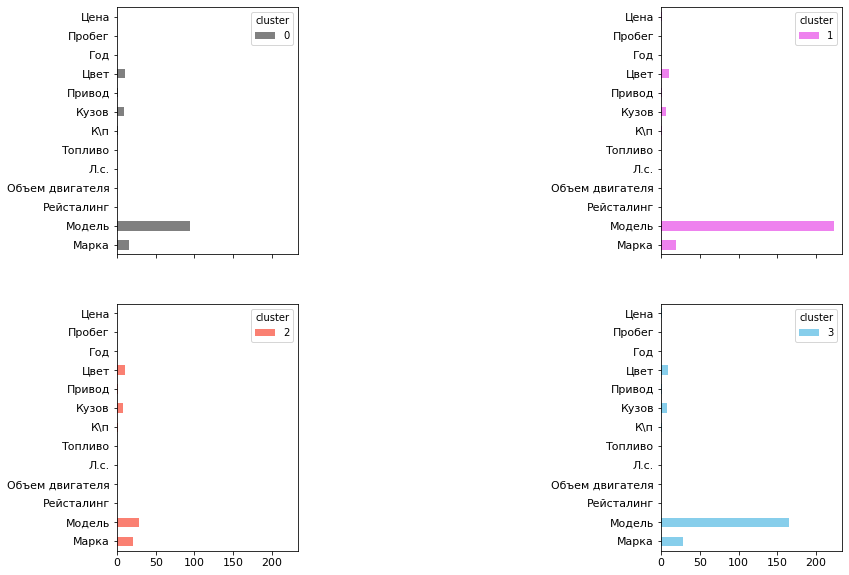

In [508]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)
fig.set_size_inches(13, 10)
plt.subplots_adjust(wspace = 2)
k = 0
c = ['grey', 'violet', 'salmon', 'skyblue', 'orange']
for i in range(2):
    for j in range(2):
        ax = axs[i, j]
        k += 1
        dt_not_nan_new[dt_not_nan_new.cluster == k-1].groupby('cluster').mean().T.plot.barh(ax = ax, color = c[k-1])
        ax.tick_params(labelsize = 11)

Из приведенной кластеризации можно выделить следущие кластеры:
- Самый важный признак, который разделяет кластеры является марка автомобиля
- Остальнаые же признаки примерно одинаковы

Осмелюсь прдположить, что данное разделение получается из-за того, что все автомобили выбирались по одному фильтру и основные показатели у них примерно одинаковы

# Линейная регрессия 

In [510]:
X = dt_not_nan.drop('Цена', axis = 1)
Y = dt_not_nan['Цена']
X.shape, Y.shape

((3153, 338), (3153,))

In [512]:
x_train, x_holdout, y_train, y_holdout = train_test_split(X, Y, test_size=0.3, random_state=17)

In [515]:
def learn(X_train, X_test, Y_train, Y_test, columns, model_name = 'LinearRegression', alphas =[0.5]):
    if model_name == 'LinearRegression':
        model = LinearRegression()
        model.fit(X_train, Y_train)
        score1 = "Качество модели (R^2) на трейнах = {}".format(model.score(X_train, Y_train))
        pred = model.predict(X_test)
        score2 = "Качество модели (R^2) на тестовых = {}".format(r2_score(Y_test, pred))
        RMSE = "RMSE = {}".format(mean_squared_error(Y_test, pred, squared = False))
        return score1, score2, RMSE
    
    elif model_name == 'Ridge':
        if len(alphas) > 1:
            return 'Передайте в гребневую регрессию один гиперпараметр'
        else:
            model = Ridge(alphas[0])
            model.fit(X_train, Y_train)
            score1 = "Качество модели (R^2) = {}".format(model.score(X_train, Y_train))
            pred = model.predict(X_test)
            score2 = "Качество модели (R^2) на тестовых = {}".format(r2_score(Y_test, pred))
            RMSE = "RMSE = {}".format(mean_squared_error(Y_test, pred, squared = False))
            return score1, score2, RMSE
 
    elif model_name == 'Lasso':
        if len(alphas) > 1:
            return 'Передайте в Лассо регрессию один гиперпараметр'
        else:
            model = Lasso(alphas[0])
            model.fit(X_train, Y_train)
            score1 = "Качество модели (R^2) = {}".format(model.score(X_train, Y_train))
            pred = model.predict(X_test)
            score2 = "Качество модели (R^2) на тестовых = {}".format(r2_score(Y_test, pred))
            RMSE = "RMSE = {}".format(mean_squared_error(Y_test, pred, squared = False))
            return score1, score2, RMSE                                      
    
    elif model_name == 'RidgeCV':
        model = RidgeCV(alphas)
        model.fit(X_train, Y_train)
        score1 = "Качество модели (R^2) = {}".format(model.score(X_train, Y_train))
        pred = model.predict(X_test)
        score2 = "Качество модели (R^2) на тестовых = {}".format(r2_score(Y_test, pred))
        RMSE = "RMSE = {}".format(mean_squared_error(Y_test, pred, squared = False))
        alpha = 'Идеальное значение альфа = {}'.format(model.alpha_)
        return score1, score2, RMSE, alpha
 
    elif model_name == 'LassoCV':
        model = LassoCV(alphas = alphas)
        model.fit(X_train, Y_train)
        score1 = "Качество модели (R^2) = {}".format(model.score(X_train, Y_train))
        pred = model.predict(X_test)
        score2 = "Качество модели (R^2) на тестовых = {}".format(r2_score(Y_test, pred))
        RMSE = "RMSE = {}".format(mean_squared_error(Y_test, pred, squared = False))
        alpha = 'Идеальное значение альфа = {}'.format(model.alpha_)
        return score1, score2, RMSE, alpha

In [516]:
learn(x_train, x_holdout, y_train, y_holdout, X.columns.tolist())

('Качество модели (R^2) на трейнах = 0.7921128890579386',
 'Качество модели (R^2) на тестовых = -1.219566885489777e+22',
 'RMSE = 8625666411449931.0')

In [517]:
learn(x_train, x_holdout, y_train, y_holdout, X.columns.tolist(), 
      model_name = 'Ridge', alphas = [100])

('Качество модели (R^2) = 0.5268053152432288',
 'Качество модели (R^2) на тестовых = 0.5063140529275888',
 'RMSE = 54880.14232485318')

In [518]:
learn(x_train, x_holdout, y_train, y_holdout, X.columns.tolist(), 
      model_name = 'Lasso', alphas = [100])

('Качество модели (R^2) = 0.7177765998005834',
 'Качество модели (R^2) на тестовых = 0.6733468775068747',
 'RMSE = 44640.93203663208')

In [519]:
learn(x_train, x_holdout, y_train, y_holdout, X.columns.tolist(), 
      model_name = 'RidgeCV', alphas = np.linspace(0.01, 1000, 1000))

('Качество модели (R^2) = 0.7840915310034161',
 'Качество модели (R^2) на тестовых = 0.701654195069107',
 'RMSE = 42662.84509297324',
 'Идеальное значение альфа = 1.010990990990991')

In [521]:
learn(x_train, x_holdout, y_train, y_holdout, X.columns.tolist(), 
      model_name = 'LassoCV', alphas = np.linspace(0.01, 1000, 1000))

('Качество модели (R^2) = 0.7798791310554616',
 'Качество модели (R^2) на тестовых = 0.6992904447265185',
 'RMSE = 42831.51741333341',
 'Идеальное значение альфа = 22.031801801801805')

In [522]:
alph = np.linspace(0.01, 1000, 1000)
ElastCV = ElasticNetCV(l1_ratio = 0.6, alphas = alph, cv = 10).fit(x_train, y_train)
pred = ElastCV.predict(x_holdout)
print("Качество модели (R^2) на тестовых = {}".format(r2_score(y_holdout, pred)))
print("RMSE = {}".format(mean_squared_error(y_holdout, pred, squared = False)))
print("Лучшая alpha = {}".format(ElastCV.alpha_))

Качество модели (R^2) на тестовых = 0.6717906120203966
RMSE = 44747.14652880632
Лучшая alpha = 0.01


Лучшие покатели качества модели показала модель RidgeCV

# Форма ввода

На её основе предскажем значения цен на автомобили, которые вводит пользователь

In [654]:
print('Введите данные в следующем порядке: ')
mark = input('Марка: ')
model = input('Модель: ')
restal = int(input('Рейсталинг: '))
dv = float(input('Объем двигателя: '))
ls = float(input('Л.с.: '))
top = input('Топливо: ')
kp = input('К\п: ')
kuz = input('Кузов: ')
pr = input('Привод: ')
col = input('Цвет: ')
year = int(input('Год: '))
km = float(input('Пробег: '))

sp = [mark, model, restal, dv, ls, top, kp, kuz, pr, col, year, km]

Введите данные в следующем порядке: 
Марка: LADA
Модель: (ВАЗ) Granta I
Рейсталинг: 1
Объем двигателя: 1.6
Л.с.: 87
Топливо: Бензин
К\п: механика
Кузов: седан
Привод: передний
Цвет: Standard
Год: 2020
Пробег: 68702.0


In [777]:
dict_ = dict()
for ind, col in enumerate(dt.columns):
    if col != 'Цена':
        dict_[col] = [sp[ind]]
new = pd.DataFrame(dict_)
new

,Марка,Модель,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Кузов,Привод,Цвет,Год,Пробег
0,LADA,(ВАЗ) Granta I,1,1.6,87.0,Бензин,механика,седан,передний,Standard,2020,68702.0


In [794]:
value = dt.dropna(how = 'any')
value.index = [ind for ind, val in enumerate(list(value.index))]
value.loc[0] = new.loc[0]
value

,Марка,Модель,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Кузов,Привод,Цвет,Год,Пробег,Цена
0,LADA,(ВАЗ) Granta I,1,1.6,87.0,Бензин,механика,седан,передний,Standard,2020,68702.0,NaN
1,Chevrolet,Aveo I,1,1.2,84.0,Бензин,механика,седан,передний,чёрный,2011,148900.0,289000.0
2,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,Бензин,механика,внедорожник 3 дв.,полный,белый,2014,33950.0,370000.0
3,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,Бензин,механика,внедорожник 3 дв.,полный,зелёный,2015,53500.0,335000.0
4,LADA,(ВАЗ) 2104,0,1.6,74.0,Бензин,механика,универсал 5 дв.,задний,синий,2011,43000.0,245000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3148,Chevrolet,Niva I,1,1.7,80.0,Бензин,механика,внедорожник 5 дв.,полный,серебристый,2016,56000.0,500000.0
3149,Nissan,Almera III (G15),0,1.6,102.0,Бензин,автомат,седан,передний,белый,2017,127000.0,500000.0
3150,Datsun,on-DO I,0,1.6,87.0,Бензин,механика,седан,передний,чёрный,2015,50000.0,345000.0
3151,Chevrolet,Aveo II,0,1.6,115.0,Бензин,механика,седан,передний,чёрный,2012,131000.0,450000.0


In [795]:
X = value.drop('Цена', axis = 1)
Y = value['Цена']

In [796]:
categorials= [column for column in X.columns if X[column].dtype == 'object']
numerical_columns = [column for column in X.columns if X[column].dtype != 'object']

In [797]:
enc = LabelEncoder()

for col in categorials:
    if X[col].nunique() <= 4:
        col_encoder = pd.Series(enc.fit_transform(X[col]))
        X[col] = col_encoder
X.head()

,Марка,Модель,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Кузов,Привод,Цвет,Год,Пробег
0,LADA,(ВАЗ) Granta I,1,1.6,87.0,0,2,седан,1,Standard,2020,68702.0
1,Chevrolet,Aveo I,1,1.2,84.0,0,2,седан,1,чёрный,2011,148900.0
2,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,0,2,внедорожник 3 дв.,2,белый,2014,33950.0
3,LADA,(ВАЗ) 2121 (4x4) I,1,1.7,83.0,0,2,внедорожник 3 дв.,2,зелёный,2015,53500.0
4,LADA,(ВАЗ) 2104,0,1.6,74.0,0,2,универсал 5 дв.,0,синий,2011,43000.0


In [798]:
OHE = OneHotEncoder(sparse=False) 

for col in categorical_columns:
    if X[col].nunique() > 4:
        col_encoder = pd.DataFrame(OHE.fit_transform(X[col].values.reshape(-1, 1)))
        X = pd.concat([col_encoder, X], axis = 1)
        X.drop(col, axis = 1, inplace = True)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Привод,Год,Пробег
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,1.6,87.0,0,2,1,2020,68702.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,1.2,84.0,0,2,1,2011,148900.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,1.7,83.0,0,2,2,2014,33950.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1,1.7,83.0,0,2,2,2015,53500.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1.6,74.0,0,2,0,2011,43000.0


In [800]:
scaler = MinMaxScaler(feature_range = (0, 1))
for col in numerical_columns:
    if col != 'Цена':
        X[col] = scaler.fit_transform(X[col].values.reshape(-1, 1))
X.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,Рейсталинг,Объем двигателя,Л.с.,Топливо,К\п,Привод,Год,Пробег
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.36,0.222222,0,2,1,1.0,0.088213
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.20,0.204678,0,2,1,0.1,0.191338
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.40,0.198830,0,2,2,0.4,0.043526
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.40,0.198830,0,2,2,0.5,0.068665
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.36,0.146199,0,2,0,0.1,0.055163


In [814]:
model = RidgeCV(np.linspace(0.01, 1000, 1000))
model.fit(X.loc[1:], Y.loc[1:])
pred = model.predict(np.array(X.loc[0]).reshape(1, -1))
print('Примерная цена автомобиля в соответствии с Вашими критерями составляет: ', round(pred[0], 2))

Примерная цена автомобиля в соответствии с Вашими критерями составляет:  482088.33
